In [21]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
import datetime
from datetime import date

In [23]:
from alpha_vantage.timeseries import TimeSeries
import time

In [24]:
api_key='8GP70P35XCP05I0P'

In [25]:
ts=TimeSeries(key=api_key,output_format='pandas')

In [26]:
data,meta_data=ts.get_daily(symbol='GBPUSD',outputsize='full')

In [27]:
data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-02-27,1.2673,1.2689,1.2601,1.2602,0.0
2025-02-26,1.2661,1.2716,1.2635,1.2674,0.0
2025-02-25,1.2624,1.2678,1.2605,1.2665,0.0
2025-02-24,1.2636,1.2691,1.2612,1.2624,0.0
2025-02-21,1.2668,1.2678,1.2625,1.2632,0.0


In [28]:
meta_data

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GBPUSD',
 '3. Last Refreshed': '2025-02-27',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [29]:
data.columns=[['open', ' high', 'low', ' close', 'volume']]
#renamimg columns

In [30]:
data.shape

(5000, 5)

In [31]:
data.isnull().sum()

open      0
 high     0
low       0
 close    0
volume    0
dtype: int64

In [32]:
data.duplicated().sum()

0

# ploting 

In [37]:
rollmean=data['open'].rolling(50).mean() # the moving average

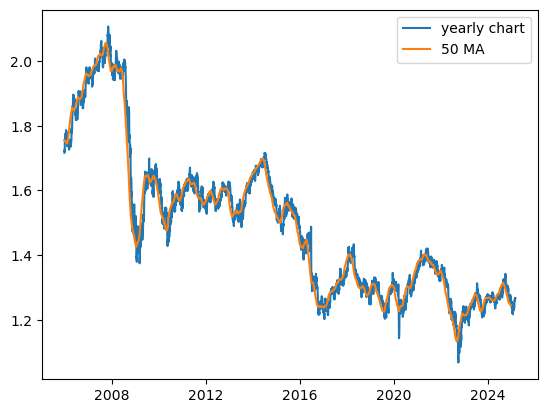

In [39]:
plt.plot(data['open'],label='yearly chart')
plt.plot(rollmean,label='50 MA')
plt.legend()

In [40]:
data.dtypes

open      float64
 high     float64
low       float64
 close    float64
volume    float64
dtype: object

In [41]:
open_price=data[['open']]

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [43]:
scaler=MinMaxScaler(feature_range=(0,1))

In [44]:
scaler_data=scaler.fit_transform(open_price)

In [45]:
# feature sequence
x=[]
y=[]
for i in range(60,len(scaler_data)):
    x.append(scaler_data[i-60:i])
    y.append(scaler_data[i])

x=np.array(x)
y=np.array(y)

In [46]:
x.shape,y.shape

((4940, 60, 1), (4940, 1))

In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [48]:
x_train.shape

(3458, 60, 1)

In [ ]:
# model builing

In [49]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [50]:
model=Sequential()

In [51]:
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.3))

In [52]:
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.3))

In [53]:
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.3))

In [54]:
model.add(Dense(units=1))

In [55]:
# compile
model.compile(optimizer='adam',loss='mean_absolute_error')

In [56]:
# fit the model
lstm_model=model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=32,epochs=10)

Epoch 1/10
109/109 [==============================] - 41s 233ms/step - loss: 0.0727 - val_loss: 0.0207
Epoch 2/10
109/109 [==============================] - 22s 205ms/step - loss: 0.0451 - val_loss: 0.0171
Epoch 3/10
109/109 [==============================] - 26s 240ms/step - loss: 0.0417 - val_loss: 0.0389
Epoch 4/10
109/109 [==============================] - 29s 269ms/step - loss: 0.0394 - val_loss: 0.0208
Epoch 5/10
109/109 [==============================] - 29s 269ms/step - loss: 0.0369 - val_loss: 0.0193
Epoch 6/10
109/109 [==============================] - 29s 267ms/step - loss: 0.0337 - val_loss: 0.0159
Epoch 7/10
109/109 [==============================] - 29s 266ms/step - loss: 0.0337 - val_loss: 0.0175
Epoch 8/10
109/109 [==============================] - 29s 264ms/step - loss: 0.0324 - val_loss: 0.0181
Epoch 9/10
109/109 [==============================] - 29s 271ms/step - loss: 0.0306 - val_loss: 0.0326
Epoch 10/10
109/109 [==============================] - 30s 276ms/step - l

In [57]:
# plotting the loss
loss=lstm_model.history['loss']
val=lstm_model.history['val_loss']

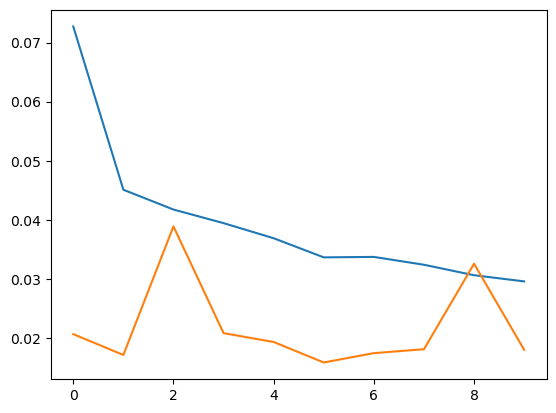

In [58]:
plt.plot(loss,label='loss')
plt.plot(val,label='validation loss')

# predictions

In [59]:
prediction=model.predict(x_test)

47/47 [==============================] - 6s 53ms/step


In [60]:
inv_pred=scaler.inverse_transform(prediction)

In [61]:
inv_y_test=scaler.inverse_transform(y_test)

In [62]:
from sklearn.metrics import mean_squared_error

In [63]:
rmse=np.sqrt(mean_squared_error(inv_y_test,inv_pred))
rmse # error difference

0.025080575570315893

In [64]:
pred_df=pd.DataFrame({'actual':inv_y_test.reshape(-1),
                     'predicted':inv_pred.reshape(-1)})
#comapring the actual vs predicted values

In [65]:
pred_df # predicted vs actual values

,actual,predicted
0,1.2886,1.294299
1,1.6546,1.637080
2,1.2508,1.264652
3,1.3021,1.305680
4,1.2518,1.252995
...,...,...
1477,1.2696,1.262119
1478,1.2148,1.215884
1479,1.3772,1.413027
1480,1.2249,1.237379


In [66]:
from statsmodels.tsa .api import SimpleExpSmoothing

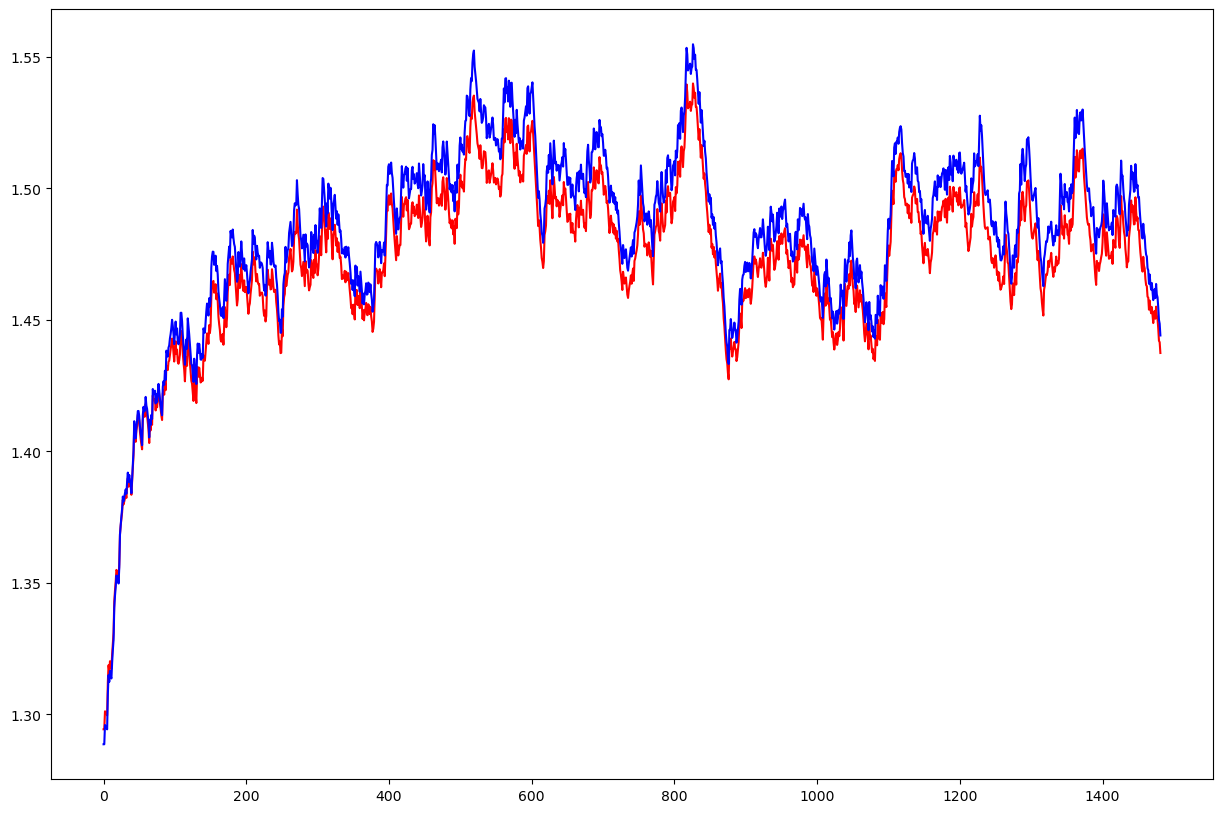

In [67]:
plt.figure(figsize=(15,10))
fit1=SimpleExpSmoothing(inv_pred).fit(smoothing_level=0.02,optimized=False)
plt.plot(fit1.fittedvalues,color='red')
fit2=SimpleExpSmoothing(inv_y_test).fit(smoothing_level=0.02,optimized=False)
plt.plot(fit2.fittedvalues,color='blue')
# visualizing the predicted vs actual

# forecast

In [86]:
forecast_date = pd.date_range(start='2025-02-27', periods=30, freq='D').tolist()

In [87]:
fore_date=[]
for time_i in forecast_date:
    fore_date.append(time_i.date())


In [88]:
n_future=30

In [89]:
next_day=scaler_data[-60:]
next_day_reshape=next_day.reshape(1,60,1)

In [123]:
future_pred=[]
for i in range (30):
    pred=model.predict(next_day_reshape)
    future_pred.append(pred[0,0])
    next_day_reshape= np.append(next_day_reshape[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    next_day_reshape[0,-1,0]=pred

1/1 [==============================] - 0s 72ms/step


C:\Users\USER\AppData\Local\Temp\ipykernel_9204\1519741867.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_day_reshape[0,-1,0]=pred


1/1 [==============================] - 0s 86ms/step


In [124]:
forecast_array=np.array(future_pred).reshape(-1,1)

In [125]:
future_pred1=scaler.inverse_transform(forecast_array)

In [126]:
f_df=pd.DataFrame({'dates':fore_df,
                   'open':future_pred1.flatten()})

ValueError: Per-column arrays must each be 1-dimensional

In [84]:
# this chart shows that in the next 6months prices will range at 1.7 price in gbpusd

In [127]:
fore_df.shape

(30, 1)

In [128]:
future_pred1.shape

(30, 1)

In [129]:
future_pred1

array([[1.7255766],
       [1.720964 ],
       [1.7166222],
       [1.712609 ],
       [1.7088965],
       [1.7054237],
       [1.702125 ],
       [1.6989449],
       [1.6958419],
       [1.6927882],
       [1.6897663],
       [1.6867672],
       [1.6837862],
       [1.6808215],
       [1.6778734],
       [1.6749419],
       [1.6720275],
       [1.6691307],
       [1.6662517],
       [1.6633906],
       [1.6605473],
       [1.6577215],
       [1.6549133],
       [1.6521221],
       [1.6493485],
       [1.6465918],
       [1.6438518],
       [1.6411285],
       [1.6384219],
       [1.6357319]], dtype=float32)

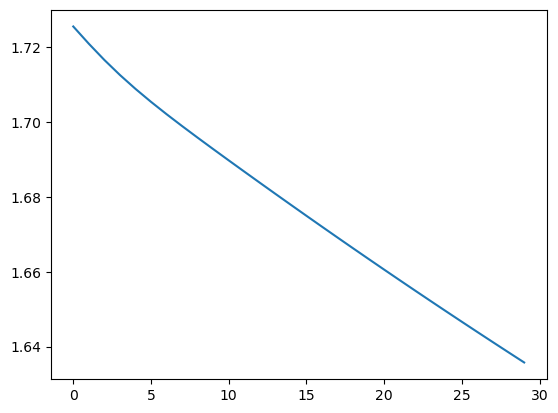

In [130]:
plt.plot(future_pred1)

In [ ]:
original=data['Open']
original_df = original.loc[original.index > '2024-09-01']

In [ ]:
roll_f=f_df['open'].rolling(50).mean()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(original)
plt.plot(f_df['dates'],f_df['open'])
plt.title('6o days predictions, full view')

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(original_df)
plt.plot(f_df['dates'],f_df['open'])
plt.title('60 days predictions, close view')
plt.grid(True)

In [ ]:
data.index.max()

In [184]:
# model saving
model.save('gbpusd_stock_model.hdf5')

In [142]:
from tensorflow.keras.layers import Conv1D,Flatten

In [134]:
cnn=Sequential()

In [139]:
cnn.add(Conv1D(64,kernel_size=3,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))

In [145]:
cnn.add(LSTM(units=50,return_sequences=True))
cnn.add(Dropout(0.5))

ValueError: Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 3712)

In [146]:
import yfinance as yf

# Fetch live GBP/USD forex data
gbpusd = yf.Ticker("GBPUSD=X")
hist = gbpusd.history(period="1d", interval="1m")  # 1-minute interval
print(hist)

                               Open      High       Low     Close  Volume  \
Datetime                                                                    
2025-02-28 00:00:00+00:00  1.259747  1.259747  1.259747  1.259747       0   
2025-02-28 00:01:00+00:00  1.259779  1.259779  1.259779  1.259779       0   
2025-02-28 00:02:00+00:00  1.259763  1.259763  1.259763  1.259763       0   
2025-02-28 00:03:00+00:00  1.259906  1.259906  1.259906  1.259906       0   
2025-02-28 00:04:00+00:00  1.259906  1.259906  1.259906  1.259906       0   
...                             ...       ...       ...       ...     ...   
2025-02-28 04:41:00+00:00  1.258622  1.258622  1.258622  1.258622       0   
2025-02-28 04:42:00+00:00  1.258622  1.258622  1.258622  1.258622       0   
2025-02-28 04:43:00+00:00  1.258511  1.258511  1.258511  1.258511       0   
2025-02-28 04:44:00+00:00  1.258431  1.258431  1.258431  1.258431       0   
2025-02-28 04:45:00+00:00  1.258527  1.258527  1.258527  1.258527       0   

In [150]:
import streamlit as st
from datetime import timedelta
today = date.today().strftime("%Y-%m-%d")
sixty_days_ago = (date.today() - timedelta(days=60)).strftime("%Y-%m-%d")  # Last 60 days
@st.cache_data
def get_one_hour_data():
    gbpusd = yf.Ticker("GBPUSD=X")
    
    # Fetch only the last 60 days of hourly data
    hist_one_hour = gbpusd.history(start=sixty_days_ago, end=today, interval="60m")
    return hist_one_hour

# Load cached data
data_one_hour = get_one_hour_data() # this the data to use

2025-02-27 21:59:58.577 No runtime found, using MemoryCacheStorageManager
2025-02-27 21:59:58.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 21:59:58.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 21:59:58.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 21:59:59.095 Thread 'Thread-12': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 21:59:59.215 Thread 'Thread-12': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 22:00:00.523 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 22:00:00.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [151]:
daily_pred=data_one_hour[['Open']]
scaled_data=scaler.transform(daily_pred)

x_v=[]
y_v=[]
for i in range (60,len(scaled_data)):
      x_v.append(scaled_data[i-60:i])
      y_v.append(scaled_data[i])
x_v=np.array(x_v)
y_v=np.array(y_v)

from sklearn.model_selection import train_test_split
x_train_h,x_test_h,y_train_h,y_test_h=train_test_split(x_v,y_v,test_size=0.3,random_state=42)


C:\Users\USER\anaconda3\anaconda4\envs\tensorr\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [153]:
x_train_h.shape

(661, 60, 1)

In [152]:
hourly_model=Sequential()

In [154]:
hourly_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_h.shape[1],x_train.shape[2])))
hourly_model.add(Dropout(0.3))

In [155]:
hourly_model.add(LSTM(units=50,return_sequences=True))
hourly_model.add(Dropout(0.3))

In [156]:
hourly_model.add(LSTM(units=50,return_sequences=False))
hourly_model.add(Dropout(0.3))

In [157]:
hourly_model.add(Dense(units=1))

In [160]:
hourly_model.compile(optimizer='adam',loss='mean_absolute_error')

In [161]:
lstn=hourly_model.fit(x_train_h,y_train_h,validation_data=(x_test_h,y_test_h),batch_size=32,epochs=5)

Epoch 1/5
21/21 [==============================] - 27s 397ms/step - loss: 0.0448 - val_loss: 0.0064
Epoch 2/5
21/21 [==============================] - 4s 213ms/step - loss: 0.0200 - val_loss: 0.0071
Epoch 3/5
21/21 [==============================] - 5s 249ms/step - loss: 0.0176 - val_loss: 0.0063
Epoch 4/5
21/21 [==============================] - 5s 216ms/step - loss: 0.0162 - val_loss: 0.0073
Epoch 5/5
21/21 [==============================] - 4s 210ms/step - loss: 0.0147 - val_loss: 0.0086


In [162]:
los=lstn.history['loss']

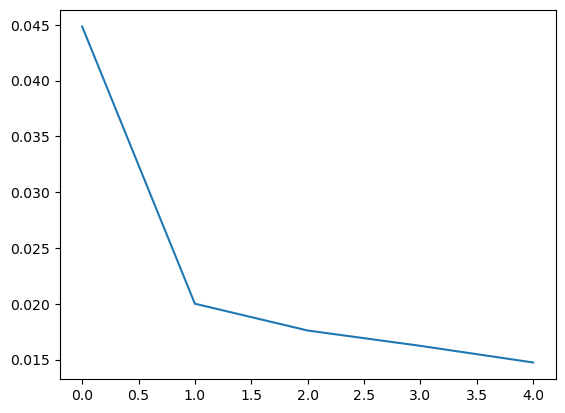

In [163]:
plt.plot(los)

In [179]:
one_hour=scaled_data[-60:]
one_day_reshape=one_hour.reshape(1,60,1)
daily_pred=[]
for i in range (24):
    pred1=hourly_model.predict(one_day_reshape)
    daily_pred.append(pred1[0,0])
    one_day_reshape= np.append(one_day_reshape[:, 1:, :], [[[pred1[0, 0]]]], axis=1)
    one_day_reshape[0,-1,0]=pred1

1/1 [==============================] - 4s 4s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_9204\148632818.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  one_day_reshape[0,-1,0]=pred1


1/1 [==============================] - 0s 80ms/step


In [180]:
one_forecast_array=np.array(daily_pred).reshape(-1,1)
ture_pred1=scaler.inverse_transform(one_forecast_array)

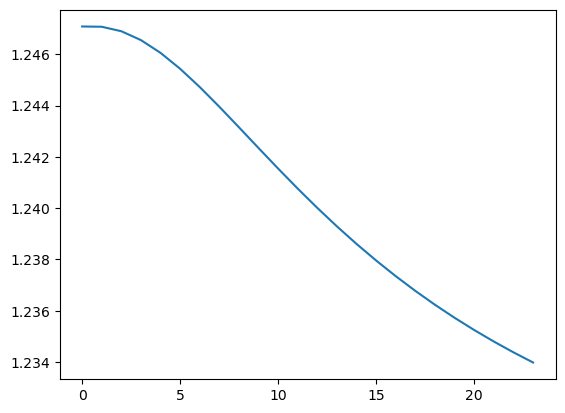

In [181]:
plt.plot(ture_pred1)

In [178]:
model2=hourly_model.save('hourly_model_forex.h5')

In [183]:
import requests
print(requests.__version__)

2.32.3


In [185]:
import h5py
print(h5py.__version__)

3.12.1
